In [1]:
%matplotlib notebook
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.linear_model import LinearRegression as LR
import numpy as np
import emcee
from joblib import dump, load
import os
#from schwimmbad import MPIPool
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import math

In [2]:
cwd = os.getcwd()

In [3]:
#emulator models (stand in for actual GAMMA model)
#4 sec to load in
stellar_mass_em = load(r'C:\\Users\\carli\\Documents\\Astrophysics General\\iCER ACRES\\GAMMA-EM\\stellar_mass_emulator.joblib')
metallicity_em = load(r'C:\\Users\\carli\\Documents\\Astrophysics General\\iCER ACRES\\GAMMA-EM\\metallicity_emulator.joblib')

In [4]:
x = np.load(r'C:\\Users\\carli\\Documents\\Astrophysics General\\iCER ACRES\\GAMMA-EM\\sample_sets\\em_sample_points200.npy')
true_y = np.load(r'C:\\Users\\carli\\Documents\\Astrophysics General\\iCER ACRES\\GAMMA-EM\\sample_sets\\gal_Mstar_200.npy')

In [5]:
print(stellar_mass_em[2].score(x,np.log10(true_y[:,2])))
#proof the loaded in emulators work

0.8747291080573976


In [6]:
obs = np.loadtxt(open("C:/Users/carli/Documents/Astrophysics General/iCER ACRES/GAMMA-EM/Observations/McConnachie Paper/McConnahie Metallicity and Mstar values.csv", "rb"), delimiter=",", skiprows=1, usecols = (0,3,4,5))
obs_Mstar = np.array(obs[:,1])
obs_FeH = obs[:,2]
obs_FeH_error = obs[:,3]
var_FeH = np.mean(obs_FeH_error)**2

In [7]:
obs_fit = LR().fit(obs_Mstar.reshape(-1,1),obs_FeH)

In [8]:
#log-likelihood function
#recieve individual variable parameters
#put them in an array
#feed that into the prediction model
#get back predicted results and N by N covariance matrix (yay sklearn gives back the right one)
#calculate log_prob between APOGEE observation and model results
var_range = np.zeros([10,2]) # should eventually pull this from GAMMA sampler
var_range[0] = [0.0,2.0]
var_range[1] = [1.0,10.0]
var_range[2] = [-1.0,1.0]
var_range[3] = [.001,.1]
var_range[4] = [.05,.5]
var_range[5] = [0.0,2.0] 
var_range[6] = [0.0,2.0] 
var_range[7] = [0.0,2.0] 
var_range[8] = [0.0,1.0] 
var_range[9] = [.0008,.002]

print("Observations loaded in")

#log-likelihood function
#calculate log_prob between APOGEE observation and model results

def log_red_chi_2(position):
    for i in range(len(var_range)):
        if not var_range[i][0] < position[i] < var_range[i][1]:
            return -np.inf
    calc_Mstar = np.zeros([len(stellar_mass_em)])
    calc_FeH = np.zeros([len(stellar_mass_em)])
    obs_FeH = np.zeros([len(stellar_mass_em)])
    pos = np.array(position)
    #print(pos)
    for i in range(len(stellar_mass_em)):
        calc_Mstar[i] = stellar_mass_em[i].predict(pos.reshape(1,-1))
        calc_FeH[i] = metallicity_em[i].predict(pos.reshape(1,-1))
        obs_FeH[i] = obs_fit.predict(calc_Mstar[i].reshape(1,-1))
    chi_2_FeH = -0.5*(np.sum(((obs_FeH-calc_FeH)**2/(var_FeH)))) #- np.log(2*math.pi*(var_FeH + (obs_FeH-calc_FeH)**2)))
    red_chi_2_FeH = chi_2_FeH/(22-10)
    return float(red_chi_2_FeH)

Observations loaded in


In [14]:
#parameters to fit - eventually should pull this from the GAMMA-EM sampling script
#these starting values are just about the average of the current proposed range of values
#t_ff_index, f_t_ff, sfe_m_index, sfe, f_dyn, t_sf_z_dep, exp_ml, mass_loading, f_halo_to_gal_out, nb_1a_per_m
start = np.array([1.0,5.5,0.1,0.055,0.3,1.0,1.0,1.0,0.5, 1.0e-3])
t_ff_index = 1.0
f_t_ff = 5.5 #
sfe_m_index = 0.1 #
sfe = 0.055 #
f_dyn = 0.3
t_sf_z_dep = 1.0 
exp_ml = 1.0 
mass_loading = 1.0 #
f_halo_to_gal_out = 0.5 
nb_1a_per_m = 1.0e-3
#x = np.array(start)
#s = stellar_mass_em[0].predict(x.reshape(1, -1))
print(len(start))

10


In [15]:
#number of parameters and walkers
ndim, nwalkers = len(start), 100
pos = np.zeros([nwalkers, ndim])
for j in range(len(pos)):
    for i in range(len(pos[0])):
        pos[j,i] = np.random.uniform(var_range[i,0],var_range[i,1])
#print(pos)
#pos = [start + 1*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_red_chi_2)
#print("Start MCMC")
sampler.run_mcmc(pos, 10)
#print("End MCMC")

(array([[ 1.07876973e+00,  4.67572466e+00,  3.25682477e-01,
          3.72246271e-02,  2.59688831e-01,  1.29970976e+00,
          1.66447574e+00,  6.69348003e-01,  4.79074249e-01,
          1.27985644e-03],
        [ 6.73102305e-01,  8.47192182e+00,  3.99010765e-01,
          7.39124943e-02,  1.83736079e-01,  5.63100914e-01,
          7.13895002e-01,  1.34297316e+00,  5.34420373e-01,
          1.18712738e-03],
        [ 3.23132028e-01,  4.53354376e+00, -1.36875616e-01,
          5.00520285e-02,  3.14953039e-01,  8.11910498e-01,
          1.41251722e+00,  2.08650477e-02,  2.28425612e-01,
          8.14666576e-04],
        [ 7.41832937e-01,  5.72031165e+00,  4.19067431e-01,
          5.71120686e-02,  1.76864970e-01,  9.10268577e-01,
          1.38481817e+00,  3.58769400e-01,  4.66038231e-01,
          1.49001837e-03],
        [ 1.27966300e+00,  2.39062665e+00, -4.81749473e-01,
          7.14722041e-02,  2.61875883e-01,  1.41637738e+00,
          6.17551967e-01,  1.64895085e+00,  4.651688

In [16]:
flat_sample = sampler.chain[1,:, :].reshape((-1, ndim))
print(flat_sample)
print(sampler.acceptance_fraction)
print(sampler.lnprobability)

[[1.05298912e+00 8.27468546e+00 1.35142028e-01 8.74862283e-02
  1.47854482e-01 1.02597468e+00 1.09095225e+00 1.74914089e+00
  3.60520918e-01 1.16030205e-03]
 [1.05298912e+00 8.27468546e+00 1.35142028e-01 8.74862283e-02
  1.47854482e-01 1.02597468e+00 1.09095225e+00 1.74914089e+00
  3.60520918e-01 1.16030205e-03]
 [1.02788989e+00 8.28156198e+00 1.17256459e-01 8.64785611e-02
  1.45683818e-01 9.92771644e-01 1.11446943e+00 1.73941900e+00
  3.60752681e-01 1.15156199e-03]
 [1.02788989e+00 8.28156198e+00 1.17256459e-01 8.64785611e-02
  1.45683818e-01 9.92771644e-01 1.11446943e+00 1.73941900e+00
  3.60752681e-01 1.15156199e-03]
 [7.18513967e-01 8.21027968e+00 4.24271458e-01 7.28859939e-02
  1.79342604e-01 6.09604359e-01 7.28471312e-01 1.32439637e+00
  5.57398936e-01 1.22009734e-03]
 [7.18513967e-01 8.21027968e+00 4.24271458e-01 7.28859939e-02
  1.79342604e-01 6.09604359e-01 7.28471312e-01 1.32439637e+00
  5.57398936e-01 1.22009734e-03]
 [7.18513967e-01 8.21027968e+00 4.24271458e-01 7.28859939e

<IPython.core.display.Javascript object>


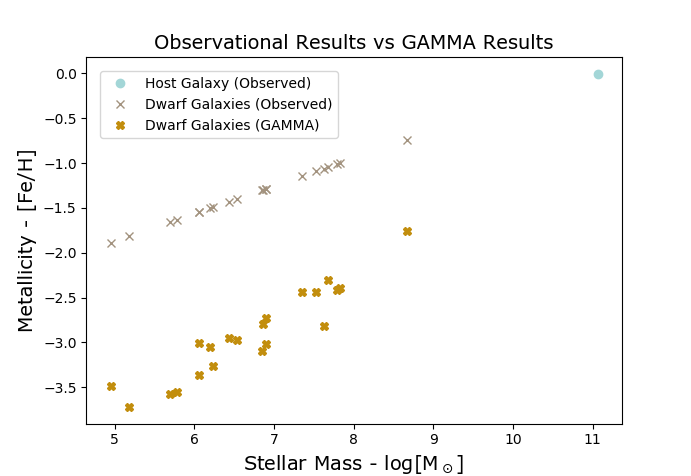

-0.9139078823104089
-348.45383077290177


In [10]:
%matplotlib notebook
#t_ff_index, f_t_ff, sfe_m_index, sfe, f_dyn, t_sf_z_dep, exp_ml, mass_loading, f_halo_to_gal_out, nb_1a_per_m
sample = np.array([2.88310891e-01,  1.89733642e+00, -8.35286788e-01 , 3.31227450e-02,
  1.77831641e-01,  3.63421166e-01 , 1.51253098e+00,  1.53679847e+00,
  6.25820635e-02,  1.52602961e-03])
calc_Mstar = np.zeros([len(stellar_mass_em)])
calc_FeH = np.zeros([len(stellar_mass_em)])
obs_FeH = np.zeros([len(stellar_mass_em)])
pos = np.array(sample)
#print(pos)
for i in range(len(stellar_mass_em)):
    calc_Mstar[i] = stellar_mass_em[i].predict(pos.reshape(1,-1))
    calc_FeH[i] = metallicity_em[i].predict(pos.reshape(1,-1))
    obs_FeH[i] = obs_fit.predict(calc_Mstar[i].reshape(1,-1))

vfont ={'fontname':'Verdana', 'size':'14'}

#calc_FeH = obs_FeH + .01
plt.errorbar(calc_Mstar[-1], obs_FeH[-1], fmt='o', color = '#A3D6D7', label = "Host Galaxy (Observed)")
plt.errorbar(calc_Mstar[:-1], obs_FeH[:-1], fmt='o', color = '#a3937f', label = "Dwarf Galaxies (Observed)", marker = "x")
#plt.errorbar(calc_Mstar[-1],calc_FeH[-1], fmt='o', color = '#6E99B4', label = "Host Galaxy (GAMMA)")
plt.errorbar(calc_Mstar[:-1],calc_FeH[:-1], fmt='o', color = '#C28E0E', label = "Dwarf Galaxies (GAMMA)", marker = "X")
plt.legend(loc="upper left", borderaxespad=1, ncol=1)
plt.title("Observational Results vs GAMMA Results", **vfont)
plt.xlabel('Stellar Mass - log[M$_\odot$]', **vfont)
plt.ylabel('Metallicity - [Fe/H]', **vfont)
#plt.xscale('log')
var = var_FeH + (obs_FeH-calc_FeH)**2
#print((obs_FeH-calc_FeH)**2/var)
#print(np.sum((obs_FeH-calc_FeH)**2/var))

chi_2_FeH = -0.5*(np.sum(((obs_FeH-calc_FeH)**2/(var_FeH + (obs_FeH-calc_FeH)**2)))) #- np.log(2*math.pi*(var_FeH + (obs_FeH-calc_FeH)**2))
print(chi_2_FeH/12)
#print(sampler.lnprobability[1])

#print((obs_FeH-calc_FeH)**2/var)
#print(np.sum((obs_FeH-calc_FeH)**2/var))

chi_2_FeH = -0.5*(np.sum(((obs_FeH-calc_FeH)**2/var_FeH))) #- np.log(2*math.pi*(var_FeH + (obs_FeH-calc_FeH)**2)))
print(chi_2_FeH/12)

<IPython.core.display.Javascript object>


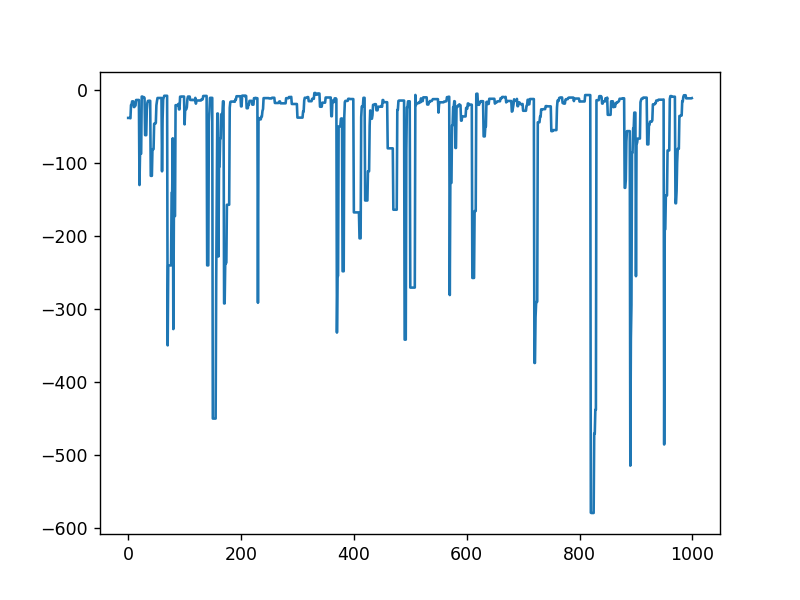

In [18]:
%matplotlib notebook
likelihood = np.asarray(sampler.flatlnprobability)
index = np.arange(0,len(likelihood))
plt.plot(index[:],likelihood[:])
plt.show()

<IPython.core.display.Javascript object>


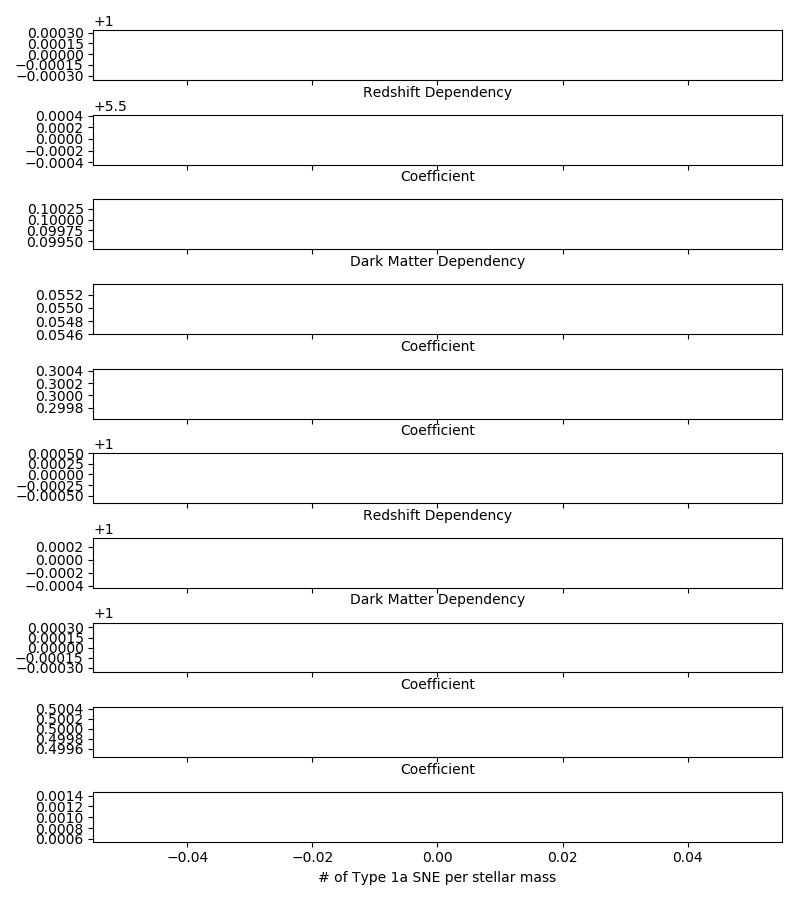